**Pipeline**

1. Read articles clean preprocessed text
2. Extract most frequent vocabulary terms (other than stop words)
3. Extract keywords and keyphrases using method in `yake` package
4. Extract frequency of occurrence of common crime terms, based on my own manually compiled lexicon of crime words.
5. Analyze frequency of occurrence of top crime terms over time (at the daily and monthly levels).

In [1]:
import pandas as pd
import re

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
import arabic_reshaper
from bidi.algorithm import get_display

In [4]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from yellowbrick.text import FreqDistVisualizer
import yake
from nltk.corpus import stopwords

C:\Users\Biware\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Read Preprocessed Data

In [6]:
import pickle

with open('../pickle/articles_db_clean.pickle', 'rb') as f:
    corpus_df = pickle.load(f)

corpus_df.shape

(7485, 7)

In [7]:
corpus_df.head()

,title,hyperlink,date,date_dt,filename,raw_text,clean_text
0,جريمة بأطوار غريبة..استيقظ الزوج ليلا فوجد زو...,https://www.assarih.com/a161665--جريمة-بأطوار-...,26 فيفري 2020,2020-02-26,www.assarih.com___جريمة_بأطوار_غريبة__استيقظ_ا...,googletag.cmd.push(function() { googletag.disp...,هي جريمة اخري ولكن باطوار وتطورات غريبة تلك ال...
1,يحدث في تونس : تلميذ يعتدي على زميلته بـ«لام» ...,https://www.assarih.com/a161660-يحدث-في-تونس--...,26 فيفري 2020,2020-02-26,www.assarih.com__يحدث_في_تونس___تلميذ_يعتدي_عل...,googletag.cmd.push(function() { googletag.disp...,تمكنت دورية تابعة لمركز الحرس الوطني ببومهل من...
2,حملة أمنية في بنزرت (صور),https://www.assarih.com/a161656-حملة-أمنية-في-...,26 فيفري 2020,2020-02-26,www.assarih.com__حملة_أمنية_في_بنزرت__صور_.txt,https://www.assarih.com/a158092-حملة-أمنية-في-...,صور من حملة امنية بمدينة بنزرت واكبتها الصريح ...
3,"تزامنا مع التخوفات من ""كورونا"" : وفاة جديدة با...",https://www.assarih.com/a161648-تزامنا-مع-التخ...,26 فيفري 2020,2020-02-26,www.assarih.com__تزامنا_مع_التخوفات_من__كورونا...,googletag.cmd.push(function() { googletag.disp...,تم اليوم الاربعاء 26 فيفري 2020 تسجيل حالتي اص...
4,تورط في 10 قضايا تحويل وجهة : سفاح النساء بالا...,https://www.assarih.com/a161647-تورط-في-10-قضا...,26 فيفري 2020,2020-02-26,www.assarih.com__تورط_في_10_قضايا_تحويل_وجهة__...,googletag.cmd.push(function() { googletag.disp...,تمكن اعوان واطارات شرطة رياض النصر باريانة من ...


*****

****

## Extract Most Frequent Words

In [8]:
stopwords_ar = stopwords.words('arabic')
len(stopwords_ar)

248

In [9]:
stopwords_ar

['إذ',
 'إذا',
 'إذما',
 'إذن',
 'أف',
 'أقل',
 'أكثر',
 'ألا',
 'إلا',
 'التي',
 'الذي',
 'الذين',
 'اللاتي',
 'اللائي',
 'اللتان',
 'اللتيا',
 'اللتين',
 'اللذان',
 'اللذين',
 'اللواتي',
 'إلى',
 'إليك',
 'إليكم',
 'إليكما',
 'إليكن',
 'أم',
 'أما',
 'أما',
 'إما',
 'أن',
 'إن',
 'إنا',
 'أنا',
 'أنت',
 'أنتم',
 'أنتما',
 'أنتن',
 'إنما',
 'إنه',
 'أنى',
 'أنى',
 'آه',
 'آها',
 'أو',
 'أولاء',
 'أولئك',
 'أوه',
 'آي',
 'أي',
 'أيها',
 'إي',
 'أين',
 'أين',
 'أينما',
 'إيه',
 'بخ',
 'بس',
 'بعد',
 'بعض',
 'بك',
 'بكم',
 'بكم',
 'بكما',
 'بكن',
 'بل',
 'بلى',
 'بما',
 'بماذا',
 'بمن',
 'بنا',
 'به',
 'بها',
 'بهم',
 'بهما',
 'بهن',
 'بي',
 'بين',
 'بيد',
 'تلك',
 'تلكم',
 'تلكما',
 'ته',
 'تي',
 'تين',
 'تينك',
 'ثم',
 'ثمة',
 'حاشا',
 'حبذا',
 'حتى',
 'حيث',
 'حيثما',
 'حين',
 'خلا',
 'دون',
 'ذا',
 'ذات',
 'ذاك',
 'ذان',
 'ذانك',
 'ذلك',
 'ذلكم',
 'ذلكما',
 'ذلكن',
 'ذه',
 'ذو',
 'ذوا',
 'ذواتا',
 'ذواتي',
 'ذي',
 'ذين',
 'ذينك',
 'ريث',
 'سوف',
 'سوى',
 'شتان',
 'عدا',
 'عسى',
 'عل'

In [10]:
MIN_DOC_FREQ = 5
MAX_DOC_FREQ = 1.0
NGRAM_RANGE = (1,2)

In [11]:
#?CountVectorizer

In [13]:
count_bow_model = CountVectorizer(min_df=MIN_DOC_FREQ, max_df=MAX_DOC_FREQ, ngram_range=NGRAM_RANGE, stop_words=stopwords_ar)

count_bow_matrix = count_bow_model.fit_transform(corpus_df.clean_text.tolist())
count_bow_vocab = count_bow_model.get_feature_names()
count_bow_matrix.shape,len(count_bow_vocab)

((7485, 23517), 23517)

In [14]:
count_bow_matrix.data.min(), count_bow_matrix.data.max()

(1, 69)

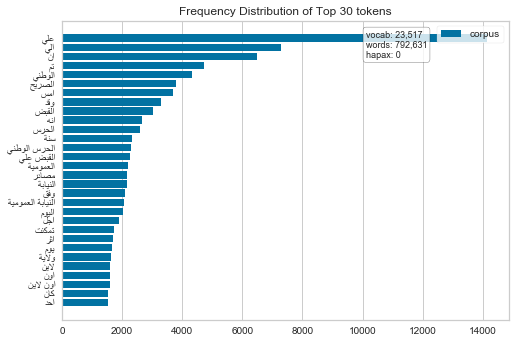

In [15]:
count_bow_vocab_reshaped = [get_display(arabic_reshaper.reshape(word)) for word in count_bow_vocab]
visualizer = FreqDistVisualizer(features=count_bow_vocab_reshaped, n=30)
visualizer.fit(count_bow_matrix)
visualizer.poof()

***

## Extract Keywords & Keyphrases

In [16]:
corpus_str = '\n'.join(corpus_df.clean_text.tolist())

In [17]:
## initialize method
kw_extractor = yake.KeywordExtractor(lan="ar", n=1, top=50, features=None)

## execute method on our corpus
%time yake_keywords = kw_extractor.extract_keywords(corpus_str)
type(yake_keywords),type(yake_keywords[0])

Wall time: 45.6 s


(list, tuple)

In [18]:
yake_keywords

[('علي', 1.737382151501654e-06),
 ('الي', 5.53365633376838e-06),
 ('الوطني', 1.186382131504944e-05),
 ('القبض', 2.2489645356197428e-05),
 ('الحرس', 3.002906122681415e-05),
 ('مصادر', 4.2465912409567625e-05),
 ('النيابة', 4.3270296485494505e-05),
 ('وفق', 4.875796967195921e-05),
 ('العمومية', 4.8792906616805206e-05),
 ('تمكنت', 6.885126535777455e-05),
 ('اون', 7.236852134002446e-05),
 ('ولاية', 7.65942013042926e-05),
 ('القاء', 8.166573879283497e-05),
 ('قضية', 8.607058277150225e-05),
 ('اذنت', 8.662910074761873e-05),
 ('مصدر', 8.755822888930369e-05),
 ('اعوان', 9.072079855873423e-05),
 ('تابعة', 9.183007370055116e-05),
 ('الامن', 0.00010286896854655098),
 ('حجز', 0.00010713076680706664),
 ('دورية', 0.0001091774927351811),
 ('وحدات', 0.00011204472606501151),
 ('علمت', 0.00012131685970193649),
 ('الابحاث', 0.00013274787729557978),
 ('تبين', 0.00013307402786293297),
 ('العدلية', 0.00013452717600490302),
 ('الاحتفاظ', 0.00013458066940520214),
 ('فرقة', 0.00013901149360740097),
 ('معه', 0.0

In [19]:
## initialize method
kw_extractor = yake.KeywordExtractor(lan="ar", n=2, top=50, features=None)

## execute method on our corpus
%time yake_keywords2 = kw_extractor.extract_keywords(corpus_str)
type(yake_keywords2),type(yake_keywords2[0])

Wall time: 54.4 s


(list, tuple)

In [20]:
yake_keywords2

[('القبض علي', 7.380998591738667e-07),
 ('علي', 1.737382151501654e-06),
 ('الحرس الوطني', 1.7548824431068827e-06),
 ('النيابة العمومية', 4.850017579354937e-06),
 ('الي', 5.53365633376838e-06),
 ('القاء القبض', 5.700363499735678e-06),
 ('علي مستوي', 6.446323162125431e-06),
 ('الوطني علي', 6.9598136440754475e-06),
 ('الامن الوطني', 9.080263855018461e-06),
 ('وفق مصادر', 9.279717205092803e-06),
 ('الوطني', 1.186382131504944e-05),
 ('العثور علي', 1.2374766225368915e-05),
 ('العمومية اذنت', 1.3178999770143993e-05),
 ('علي عين', 1.5158785056624537e-05),
 ('وحدات الحرس', 1.739662749425169e-05),
 ('علي متن', 1.756007589235035e-05),
 ('الي المستشفي', 1.8232399404560157e-05),
 ('وذلك علي', 1.824003316117282e-05),
 ('دورية تابعة', 2.0671956962289318e-05),
 ('اون لاين»', 2.0958791146688097e-05),
 ('علي خلفية', 2.117015029778334e-05),
 ('القبض', 2.2489645356197428e-05),
 ('قضية عدلية', 2.5498409328971504e-05),
 ('علي مصدر', 2.6486763923211784e-05),
 ('مصدر امني', 2.780563471453995e-05),
 ('الحرس', 

****

## Extract frequency of occurrence of crime terms
Based on my own manually compiled lexicon of crime words.

In [21]:
## Read dictionary of crime related words

with open('../resources/Crime_ontology.txt', 'r', encoding='utf8') as f:
    crime_words_lexicon = f.read().split('\n')
    crime_words_lexicon = [word.strip() for word in crime_words_lexicon if word!='']
crime_words_lexicon = sorted(list(set(crime_words_lexicon)))
len(crime_words_lexicon)

95

In [22]:
crime_words_lexicon 

['إصابة',
 'إطلاق نار',
 'ابحاث جارية',
 'اتهام',
 'اجتياز',
 'اجرام',
 'احباط',
 'احتجاز',
 'احتيال',
 'اختلاس',
 'ارتشاء',
 'استيلاء',
 'اشتباه',
 'اشتبه',
 'اضرام النار',
 'اطلاق',
 'اعتداء',
 'اعتراف',
 'اعترف',
 'اعتقال',
 'اعتقل',
 'اغتصاب',
 'الجاني',
 'الجناة',
 'الشروط الصحية',
 'القاء القبض',
 'انتحار',
 'انتحر',
 'ايقاف',
 'براكاج',
 'تحت التهديد',
 'تحرش',
 'تحري',
 'تحريات',
 'تحيل',
 'تدليس',
 'ترويج',
 'تزييف',
 'تعمد',
 'تفتيش',
 'تفجير',
 'تم ضبط',
 'تهديد',
 'تهريب',
 'جثة',
 'جرائم',
 'جرحى',
 'جريح',
 'جريمة',
 'جنسي',
 'حجز',
 'حدود',
 'حرق',
 'حيازة مخدرات',
 'خطير',
 'خطيرة',
 'خلسة',
 'دعارة',
 'دون رخصة',
 'رذيلة',
 'رشوة',
 'رصاص',
 'زطلة',
 'سجن',
 'سرقة',
 'سطو',
 'سفاح',
 'سلاح',
 'شاهد عيان',
 'شرطة',
 'شهود عيان',
 'ضحايا',
 'ضحية',
 'عصابة',
 'عملة',
 'عملية نوعية',
 'عنف',
 'غير صالح للاستهلاك',
 'غير صالحة للاستهلاك',
 'قبض على',
 'قتل',
 'لا تستجيب للشروط الصحية',
 'متاجرة مخدرات',
 'متلبس',
 'مجرم',
 'مخدرات',
 'مراقبة',
 'مروج',
 'مزيف',
 'مشتبه',
 

In [23]:
# First method: match each word separately

crime_words_df = pd.DataFrame(columns=crime_words_lexicon)
for word in crime_words_lexicon:
    #print(word)
    crime_words_df[word] = corpus_df.clean_text.str.contains(word)

In [24]:
crime_words_df.shape

(7485, 95)

In [25]:
u = crime_words_df.sum(axis=0)

In [26]:
u.describe()

count      95.000000
mean      299.810526
std       411.950222
min         0.000000
25%        18.500000
50%       176.000000
75%       363.500000
max      1976.000000
dtype: float64

In [27]:
u[u<=5].sort_values()

إصابة                      0
إطلاق نار                  0
جرائم                      0
جرحى                       0
حيازة مخدرات               0
قبض على                    0
متاجرة مخدرات              0
احتيال                     1
ارتشاء                     1
لا تستجيب للشروط الصحية    1
شاهد عيان                  3
الشروط الصحية              4
جريح                       4
غير صالح للاستهلاك         4
اعتقل                      5
dtype: int64

In [28]:
u.sort_values(ascending=False).head(30)

تحري           1976
حجز            1822
تفتيش          1665
القاء القبض    1638
سجن            1077
تحريات         1017
شرطة            975
اعتداء          925
اعترف           861
سرقة            837
عنف             832
تعمد            765
قتل             731
مخدرات          646
ايقاف           619
ترويج           593
خطير            591
تهديد           575
حدود            494
جثة             424
زطلة            396
جنسي            395
جريمة           389
ضحية            370
تهريب           357
مراقبة          344
سلاح            325
اجرام           306
عملة            277
الجاني          274
dtype: int64

In [29]:
u['استيلاء']

248

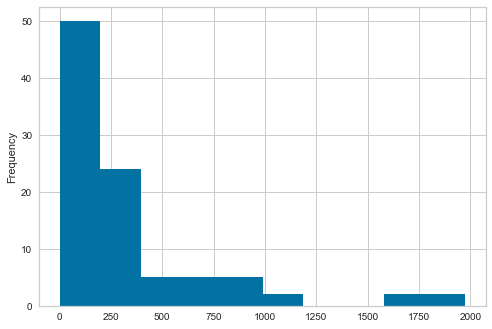

In [30]:
u.plot.hist()

Text(0.5, 0, 'word')

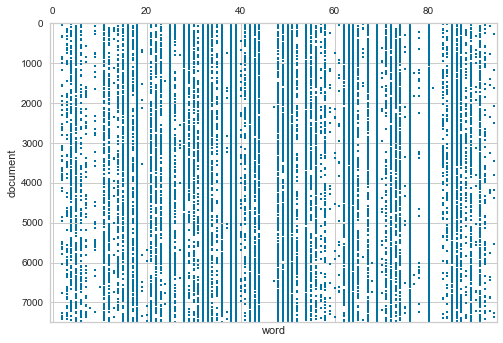

In [31]:
plt.spy(crime_words_df,precision=0, markersize=2, aspect='auto')
plt.ylabel('document')
plt.xlabel('word')

In [32]:
## Second method: using one regexp
## The problem with this method is that it can match at most one word; cannot match multiple words simultaneously

if False:
    u = '|'.join(['('+x+')' for x in crime_words_lexicon])
    crime_words_regexp = re.compile(u)

    idx = corpus_df.clean_text.str.contains(crime_words_regexp)
    idx.mean()
    %time corpus_df['crime_words'] = corpus_df.clean_text.str.extract(crime_words_regexp, expand=True)
    #%time corpus_df['crime_words'] = corpus_df.clean_text.str.findall(crime_words_regexp).map(lambda x: [] if x==[] else [y for y in x[0] if y!=''])
    z = corpus_df.crime_words.notnull().sum(axis=0)
    z.index = crime_words
    z.sort_values(ascending=False)

***

## Temporal Analysis of Frequency of Crime Words

In [33]:
corpus_df.date_dt.nunique()

352

In [34]:
corpus_df.date_dt.value_counts().head(30)

2020-02-17    37
2020-01-30    34
2020-01-28    33
2019-12-07    33
2020-02-07    33
2020-02-22    32
2020-02-14    32
2020-01-29    32
2019-05-24    31
2020-01-31    31
2019-03-25    31
2020-01-27    31
2019-03-22    31
2019-07-04    31
2019-12-14    30
2019-08-05    30
2020-02-01    30
2019-12-16    30
2019-05-11    29
2019-04-08    29
2019-04-03    29
2019-06-08    29
2020-02-04    29
2020-02-08    29
2019-11-23    29
2019-12-19    29
2020-02-10    29
2019-10-03    29
2019-11-07    29
2019-08-03    29
Name: date_dt, dtype: int64

In [35]:
corpus_df.date_dt.value_counts().tail()

2019-04-07    7
2019-04-14    7
2019-03-31    6
2019-05-05    6
2019-06-05    3
Name: date_dt, dtype: int64

In [36]:
corpus_df.sort_values(by='date_dt',inplace=True)

In [37]:
corpus_df.date_dt.iloc[0].month,corpus_df.date_dt.iloc[-1].month

(3, 2)

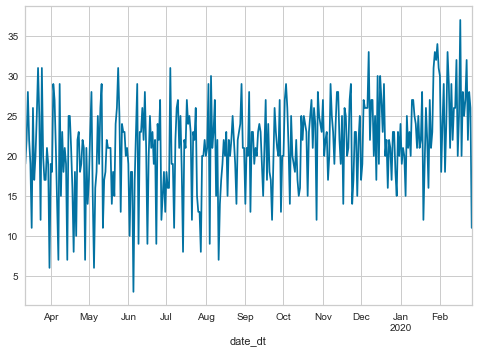

In [38]:
# Total number of articles by day

corpus_df.groupby('date_dt')['title'].count().plot()

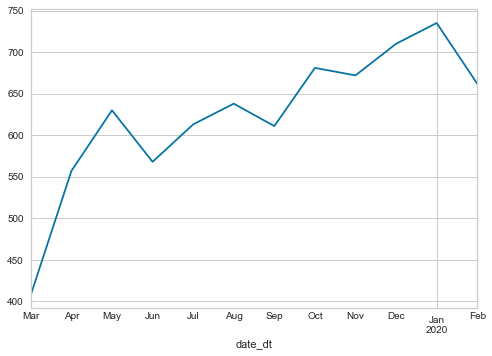

In [39]:
# Total number of articles by month

corpus_df.groupby('date_dt')['title'].count().resample(rule='M').sum().plot()

In [40]:
crime_words_df.shape

(7485, 95)

In [41]:
corpus_df.shape

(7485, 7)

In [42]:
crime_words_df.head()

,إصابة,إطلاق نار,ابحاث جارية,اتهام,اجتياز,اجرام,احباط,احتجاز,احتيال,اختلاس,...,مخدرات,مراقبة,مروج,مزيف,مشتبه,نهب,هدد,يشتبه,يعتدي,يعنف
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [43]:
top_words_df = crime_words_df.sum(axis=0).sort_values(ascending=False).head(30)

In [44]:
top_words_df.head()

تحري           1976
حجز            1822
تفتيش          1665
القاء القبض    1638
سجن            1077
dtype: int64

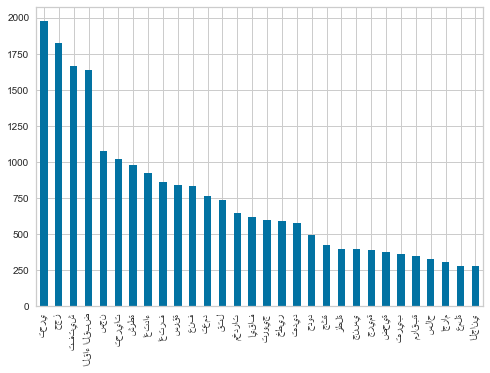

In [45]:
top_words_df.plot.bar()

In [46]:
crime_words_df.set_index(corpus_df.date_dt.iloc[0:crime_words_df.shape[0]],inplace=True)
crime_words_df.head()

,إصابة,إطلاق نار,ابحاث جارية,اتهام,اجتياز,اجرام,احباط,احتجاز,احتيال,اختلاس,...,مخدرات,مراقبة,مروج,مزيف,مشتبه,نهب,هدد,يشتبه,يعتدي,يعنف
date_dt,,,,,,,,,,,,,,,,,,,,,
2019-03-12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-03-12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-03-12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-03-12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2019-03-12,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [47]:
special_crime_words = top_words_df.index.tolist()
special_crime_words = [ 'سرقة','سطو','اغتصاب','براكاج','قتل','زطلة','مخدرات' ,'تهريب','تدليس','مزيف','دعارة','رذيلة','انتحر','انتحار','حرق','تفجير']

In [48]:
u = crime_words_df.groupby('date_dt')[special_crime_words].agg('sum')
u.sum(axis=0).sort_values(ascending=False)

سرقة      837.0
قتل       731.0
مخدرات    646.0
زطلة      396.0
تهريب     357.0
براكاج    242.0
اغتصاب    232.0
سطو       200.0
انتحار    157.0
حرق       151.0
تدليس      98.0
مزيف       86.0
دعارة      49.0
تفجير      46.0
رذيلة      19.0
انتحر       9.0
dtype: float64

In [49]:
z = u.sum(axis=1)
u.shape,z.shape

((352, 16), (352,))

In [50]:
if False:
    u.columns = [get_display(arabic_reshaper.reshape(x)) for x in u.columns]
    for i in range(u.shape[1]):
        (u.iloc[:,i]/z).plot()
        plt.title(u.columns[i])
        plt.show()

In [51]:
u2 = u.resample(rule='M').sum()
u2.head()

,سرقة,سطو,اغتصاب,براكاج,قتل,زطلة,مخدرات,تهريب,تدليس,مزيف,دعارة,رذيلة,انتحر,انتحار,حرق,تفجير
date_dt,,,,,,,,,,,,,,,,
2019-03-31,63.0,12.0,16.0,30.0,32.0,35.0,49.0,25.0,6.0,6.0,6.0,1.0,0.0,12.0,9.0,0.0
2019-04-30,90.0,26.0,9.0,44.0,41.0,46.0,69.0,55.0,6.0,6.0,3.0,0.0,1.0,8.0,13.0,2.0
2019-05-31,79.0,21.0,11.0,34.0,50.0,38.0,71.0,35.0,9.0,5.0,3.0,3.0,0.0,9.0,16.0,5.0
2019-06-30,61.0,11.0,15.0,11.0,56.0,23.0,46.0,35.0,10.0,9.0,5.0,2.0,0.0,14.0,11.0,3.0
2019-07-31,66.0,13.0,22.0,15.0,89.0,38.0,65.0,29.0,11.0,10.0,8.0,3.0,1.0,7.0,11.0,4.0


In [52]:
u.shape,u2.shape

((352, 16), (12, 16))

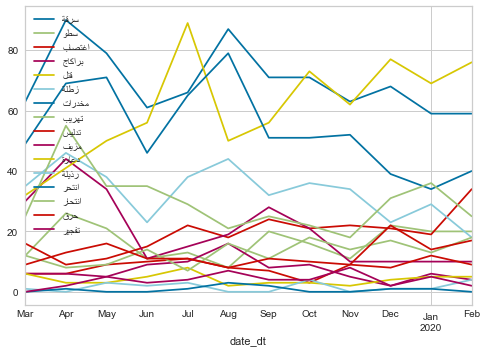

In [53]:
u2.columns = [get_display(arabic_reshaper.reshape(x)) for x in u2.columns]
u2.plot()

In [54]:
z2 = u2.sum(axis=1)
u2.shape,z2.shape

((12, 16), (12,))

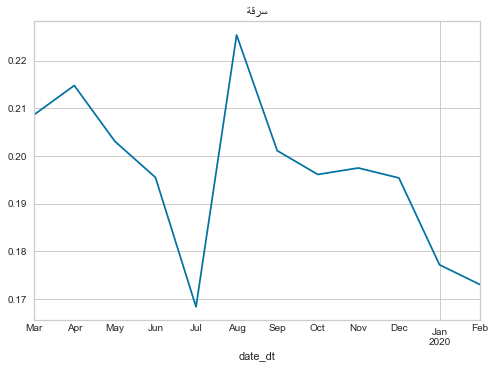

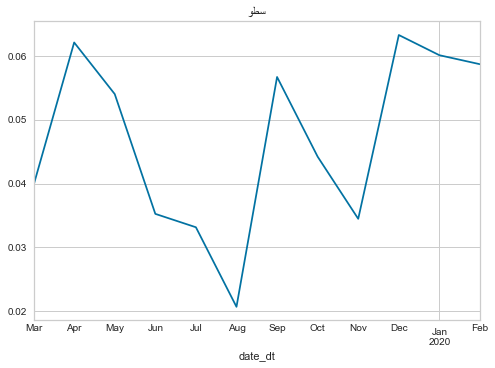

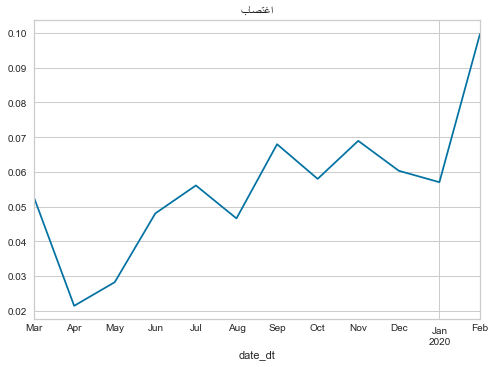

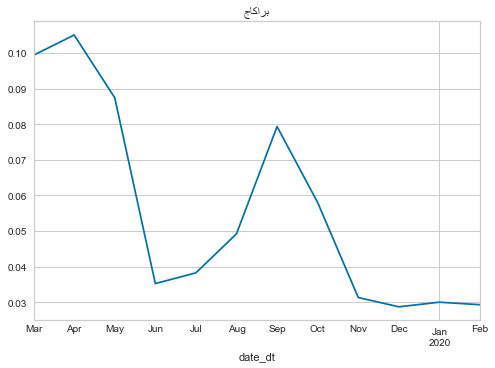

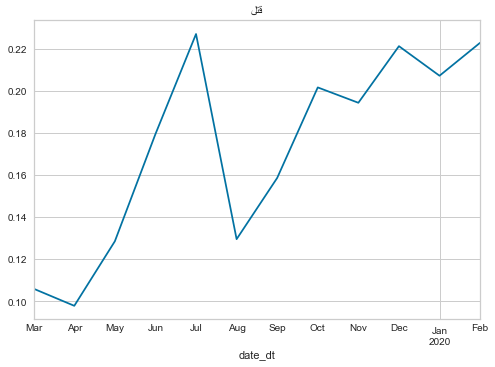

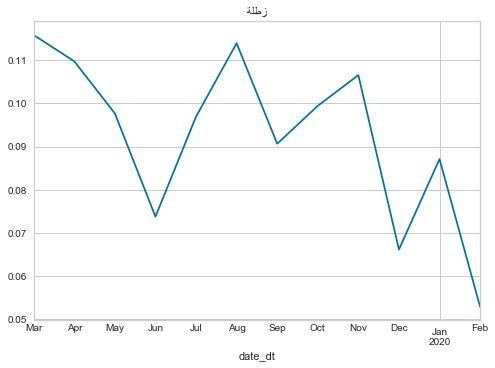

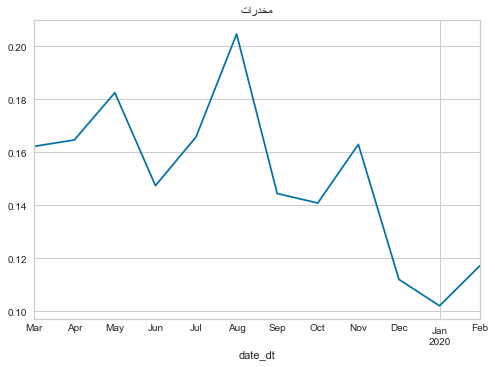

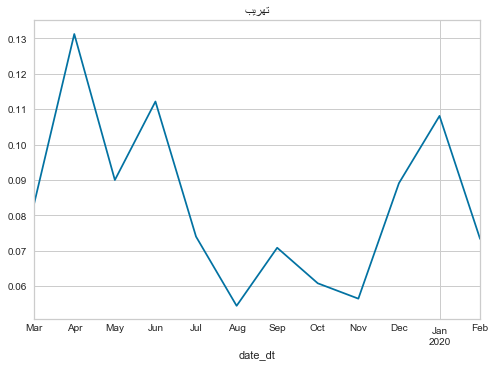

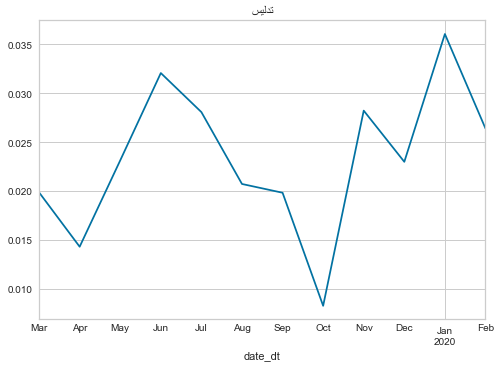

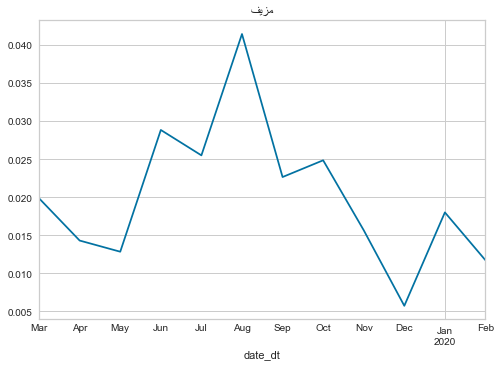

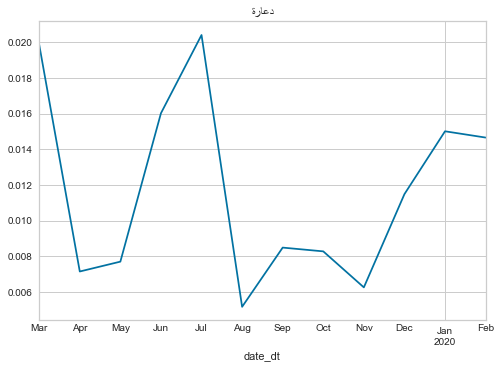

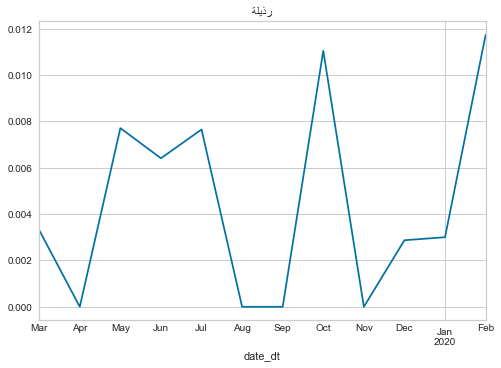

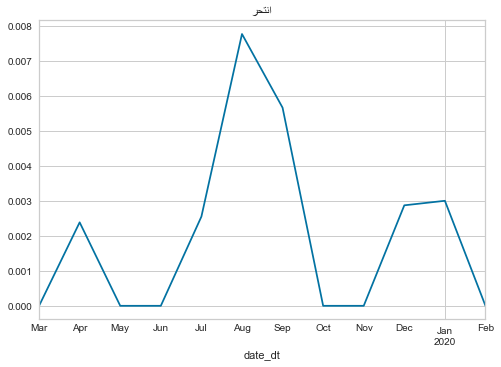

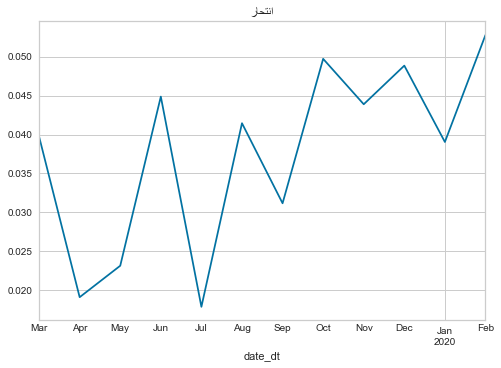

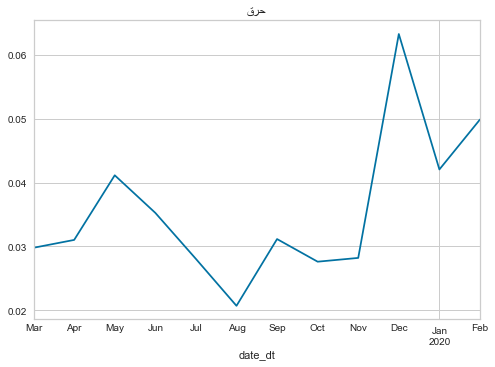

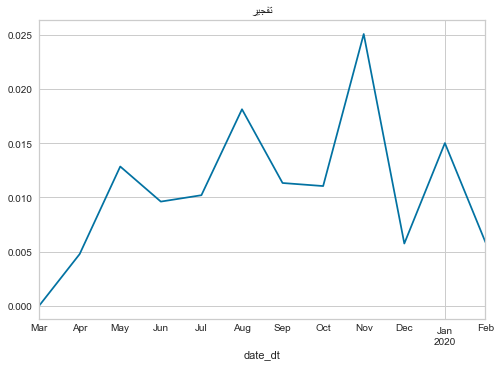

In [55]:
for i in range(u2.shape[1]):
    (u2.iloc[:,i]/z2).plot()
    plt.title(u2.columns[i])
    plt.show()